Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST Feed-Forward Neural Network

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
import matplotlib.pyplot as plt
from torch.autograd import Variable 
from torch.utils import data
from sklearn.metrics import confusion_matrix

## Initilaize Data Loader

In [2]:
def MNIST_DATA(root='./data',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = root,  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(), # convert data to tensor 
                                    download = True)  # whether to download the data
    mnist_test = vision_dsets.MNIST(root = root,
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download = True)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [3]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


## Define Trainer

In [34]:
from sklearn.metrics import confusion_matrix

class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Q1) what if we dind't clear up the gradients?
                #  A1) Whenever .background() is called, Pytorch accumulates the gradients in buffers on subsequent backward pass.
                #      If we didn't clear up them, it can be mixed with the previous gradients, and values can diverge
                #      when the number of iterations increases. So, if you don't want to mix up gradients between minibatches,
                #      you have to zero them out at the start of a new minibatch.

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Q2) Why should we change the network into eval-mode?
                        # A2) model.eval() sets the module in evaluation mode.
                        #     It is a kind of switch for some specific layers/parts (e.g. Dropout, BatchNorm) of the model
                        #     that behave differently during training and inference time.
                        #     For example, in eval mode the Dropout is deactivated and BatchNorm uses the parameters saved in training.
        test_loss = 0
        correct = 0
        
        # Data for confusion matrix
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
            
                
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))
        
    def compute_conf(self):
        self.net.eval()
        
        # Data for confusion matrix
        conf_true = torch.zeros(0, dtype=torch.long, device='cpu')
        conf_pred = torch.zeros(0, dtype=torch.long, device='cpu')

        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            
            # Append batch prediction results for confusion matrix
            conf_true = torch.cat([conf_true, labels.view(-1).cpu()])
            conf_pred = torch.cat([conf_pred, pred.view(-1).cpu()])

        # Print confusion matrix
        label_name = [str(i) for i in range(10)]
        conf_mat = confusion_matrix(conf_true.numpy(), conf_pred.numpy(), labels=[i for i in range(10)])
        print('\nConfusion matrix\n')
        print(conf_mat)

        # per-class accuracy
        conf_class_acc = 100 * conf_mat.diagonal()/conf_mat.sum(1)
        print('\nAccuracy per class\n')
        for i in range(10):
            print(i, 'th acc: ', conf_class_acc[i])

        # confusion matrix figure
        fig = plt.figure()
        ax = fig.add_subplot(111)
        for i in range(10):
            for j in range(10):
                texts = ax.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")
        cax = ax.matshow(conf_mat)
        fig.colorbar(cax)
        ax.set_xticks([i for i in range(10)])
        ax.set_yticks([i for i in range(10)])
        ax.set_xticklabels(label_name)
        ax.set_yticklabels(label_name)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

## Let's create Model by yourself

![activation](./imgs/activation.png)

### (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__() # Q3) Why do we need to call the constructor, nn.Module?
                                          # A3) 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

### (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

#### Q4) Is there any difference in performance according to the activiation function?

#### Ans) Yes. When comparing inference of ReLU and Sigmoid in the same Network, the accuracy of ReLU is about 85%, which is better than 59% of Sigmoid.

### (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

#### Q5) Is training gets done easily? If it doesn't, why not?

#### Ans) No.

### (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

#### Q6) Is training gets done easily compared to experiment (2)? If it doesn't, why not?

#### Ans)

#### Q7) What would happen if there is no activation function?

#### Ans) If there is no activation function, the output signal would simply be a single linear function. Linear equation is easy to solve but it is limited in its complexity and hard to learn complex functional mapping from data.

## Let's Change our Optimizer

![Adam](./imgs/adam.jpeg)

Reference: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

### (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

### (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

### (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

#### Q8) Is there any performance difference before/after applying the batch-norm?

#### Ans)

#### Q9) How did 2-layer neural network and 3-layer neural network behave differently after applying the batch-nrom?

#### Ans)

## HW 1.1 Let's Do It: Let's achieve performance greater than 98%!

In [20]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(1, 8, 3, 1, 1)
        self.conv0_bn = nn.BatchNorm2d(8)
        self.pool0 = nn.MaxPool2d(2)
        self.dropout0 = nn.Dropout(0.25)

        self.conv1 = nn.Conv2d(8, 16, 3, 1, 1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.fc = nn.Linear(16*7*7, 128)
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = self.dropout0(x)

        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

In [41]:
mnist_net = MNIST_Net().cuda() # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [42]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

trainer.train(epoch = 4)

[1,   500] loss: 0.416
[1,  1000] loss: 0.183
[1,  1500] loss: 0.150
[2,   500] loss: 0.108
[2,  1000] loss: 0.106
[2,  1500] loss: 0.101
[3,   500] loss: 0.079
[3,  1000] loss: 0.086
[3,  1500] loss: 0.080
[4,   500] loss: 0.069
[4,  1000] loss: 0.070
[4,  1500] loss: 0.067
Finished Training


In [43]:
trainer.test()


Test set:  Accuracy: 9881/10000 (99%)




Confusion matrix

[[ 977    1    0    0    0    0    0    1    1    0]
 [   0 1133    0    0    0    0    1    1    0    0]
 [   1    0 1026    0    0    0    0    5    0    0]
 [   0    0    5  995    0    6    0    2    1    1]
 [   0    1    1    0  969    0    2    1    0    8]
 [   2    0    0    1    0  888    1    0    0    0]
 [   6    3    0    0    1    4  943    0    1    0]
 [   0    0    6    0    1    0    0 1018    1    2]
 [   4    0    5    1    3    1    0    5  948    7]
 [   2    5    0    0    5    5    0    7    1  984]]

Accuracy per class

0 th acc:  99.6938775510204
1 th acc:  99.8237885462555
2 th acc:  99.4186046511628
3 th acc:  98.51485148514851
4 th acc:  98.67617107942974
5 th acc:  99.55156950672645
6 th acc:  98.43423799582463
7 th acc:  99.0272373540856
8 th acc:  97.3305954825462
9 th acc:  97.52229930624381


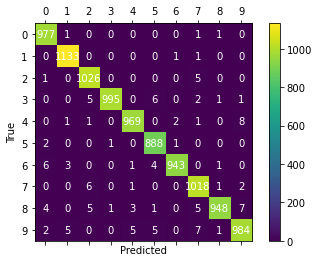

In [44]:
trainer.compute_conf()

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

103066

#### Q10) What are the problems with the large number of parameters?

#### Ans)

## Let's use Convolution Layer

### Convolution Operation

![Convolution](./imgs/Conv.png)



#### Q11) Given input image with shape:(H, W, C1), what would be the shape of output image after applying 2 (F * F) convolutional filters with stride S?
#### Ans)

### (9) 2-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

In [ ]:
count_parameters(mnist_net)

#### Q12) How did the performance and the number of parameters change after using the Convolution operation? Why did these results come out?

#### Ans)

### (10) 2-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)



In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [ ]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [ ]:
trainer.train(epoch = 4)

In [ ]:
trainer.test()

In [ ]:
count_parameters(mnist_net)

#### Q13) How did the performance change after using the Convolution operation? Why did these results come out?

#### Ans)